# Machine learning-driven sentiment analysis for movie reviews

This notebook profiles a fairly-simple machine learning model based on natural language processing and a stocastic gradient descent classifier to learn a user's feelings about a movie they reviewed. This is proof-of-concept for the moment - the larger goal is to build a classifier (or regressor?) that will accurately predict the discrete MPAA rating for a film, given its marketing decscription. 

The problem is esoteric, given than the process has to (1) comprehend the basic sentiment behind the language, and (2) discern between promotional marketing jargon and the rating of a movie - G, PG, PG-13, R, X. We obviously would not want to misclassify a rather tame synopsis for The Exorcist as PG, or Disney's Tarzan as R.

In [53]:
import nltk
import pickle
import warnings
import matplotlib.pyplot as plt
from sklearn.datasets import load_files
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.externals import joblib

# nltk.download('punkt')
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
X_train = load_files('movie_reviews_large', shuffle=True)
len(X_train.data)

42927

# computing bag-of-words & TF-IDF

In [3]:
# initialize movie_vector object, and then turn movie train data into a vector 
movie_vec = CountVectorizer(min_df=2, tokenizer=nltk.word_tokenize)
movie_counts = movie_vec.fit_transform(X_train.data)

In [4]:
movie_counts.shape

(42927, 70727)

In [5]:
# convert bag-of-words counts into TD-IDF values
tfidf_transformer = TfidfTransformer()
movie_tfidf = tfidf_transformer.fit_transform(movie_counts)

## machine learning: training/testing with various classifier algorithms

In [55]:
docs_train, docs_test, y_train, y_test = train_test_split(movie_tfidf, X_train.target, test_size=0.3, random_state=5)

''' alterative classifier algorithms '''
# this gets ~82%
# model = MultinomialNB()  

# this gets ~89%
# model = LogisticRegression()

# this gets ~83%
# model = AdaBoostClassifier(n_estimators=100, learning_rate=1.0)

# this gets ~84%
# model = RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini', random_state=0)

# this gets ~90%
model = SGDClassifier(alpha=0.0001)
model.fit(docs_train, y_train)

y_pred = model.predict(docs_test)
print('accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('confusion matrix:\n{}'.format(confusion_matrix(y_test, y_pred)))
print('classification report:\n{}'.format(classification_report(y_test, y_pred, target_names=X_train.target_names)))

accuracy: 0.895
confusion matrix:
[[5711  726]
 [ 629 5813]]
classification report:
             precision    recall  f1-score   support

        neg       0.90      0.89      0.89      6437
        pos       0.89      0.90      0.90      6442

avg / total       0.89      0.89      0.89     12879



In [75]:
# toy movie reviews to test accuracy
reviews_new = ['this movie really sucked', 'a true achievement', 
               'cannot say enough great things about this film', 'makes me want to burn the Hollywood sign to the ground', 
               'how did this get made???', 'i was riveted', 'i simply cannot wait for the sequel', 
               'if the Oscar selection committee even considers this crapola-fest for Best Picture, i am moving to Canada',
               'it makes Ishtar look like The Grapes of Wrath', 'please make Part II!', 
               'i fart with more clarity than this triumph of illiterate screenwriting', 'star wars has nothing on this', 
               'a masterpiece of budget- and time-wasting effort', 'somewhere, somehow, Eric Roberts smiles in stoic approval', 
               'this blows donkey balls',  'greatest thing since sliced wonder bread', 
               'the production quality needs a lot of work', 'overall, it left much to be desired', 
               'lol', 'omfg, this was bomb', 'i would rate this movie as excrement, but that would be an insult to excrement', 
               'watch it on repeat, loop even']
reviews_new_counts = movie_vec.transform(reviews_new)
reviews_new_tfidf = tfidf_transformer.transform(reviews_new_counts)
pred = model.predict(reviews_new_tfidf)

In [76]:
# show the classification 
for review, category in zip(reviews_new, pred):
    print('{} => {}'.format(review, X_train.target_names[category]))

this movie really sucked => neg
a true achievement => pos
cannot say enough great things about this film => pos
makes me want to burn the Hollywood sign to the ground => neg
how did this get made??? => neg
i was riveted => pos
i simply cannot wait for the sequel => neg
if the Oscar selection committee even considers this crapola-fest for Best Picture, i am moving to Canada => pos
it makes Ishtar look like The Grapes of Wrath => pos
please make Part II! => neg
i fart with more clarity than this triumph of illiterate screenwriting => pos
star wars has nothing on this => neg
a masterpiece of budget- and time-wasting effort => pos
somewhere, somehow, Eric Roberts smiles in stoic approval => pos
this blows donkey balls => neg
greatest thing since sliced wonder bread => neg
the production quality needs a lot of work => neg
overall, it left much to be desired => neg
lol => pos
omfg, this was bomb => neg
i would rate this movie as excrement, but that would be an insult to excrement => neg
watc

In [58]:
# perist the model
joblib.dump(model, 'movie_sentiment.joblib')

['movie_sentiment.joblib']

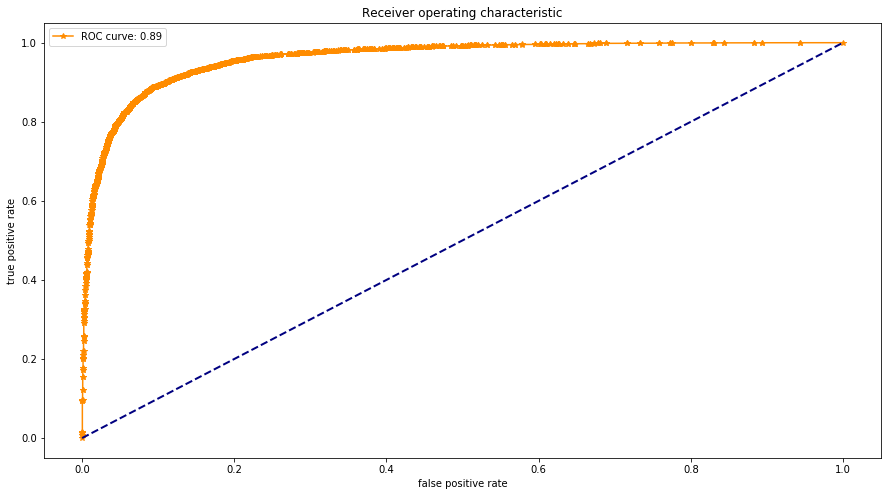

In [59]:
# compute ROC and AUC for each class
probabilities = model.decision_function(docs_test)
fpr, tpr, _ = roc_curve(y_test, probabilities)

plt.figure(figsize=(15, 8))
plt.plot(fpr, tpr, color='darkorange', label='ROC curve: {:.2f}'.format(accuracy_score(y_test, y_pred)), marker='*')
plt.plot([0,1], [0,1], color='navy', linestyle='--', lw=2)
plt.title('Receiver operating characteristic')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='best')
plt.show()

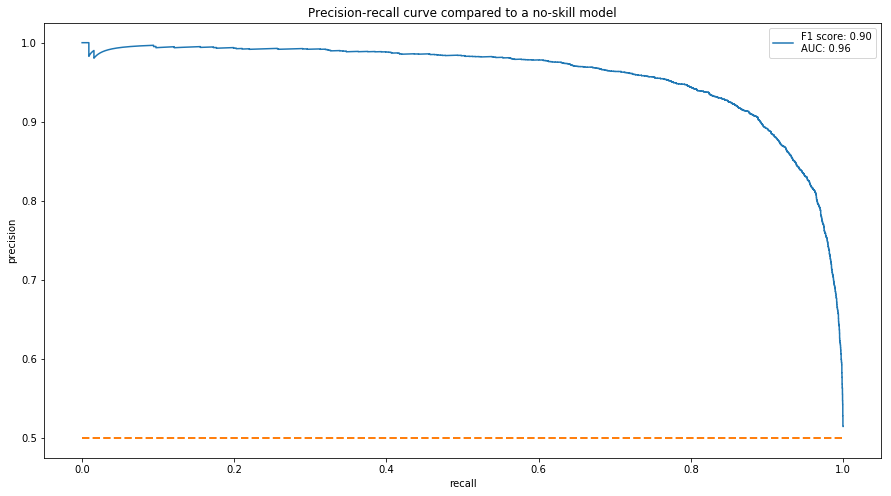

In [60]:
# visualize the model's precision-recall relationship
probs = model.decision_function(docs_test)
precision, recall, _ = precision_recall_curve(y_test, probs)

# f1 score and AUC
f1 = f1_score(y_test, y_pred)
area_under_curve = auc(recall, precision)

# plot the precision-recall curve
plt.figure(figsize=(15, 8))
plt.plot(recall, precision, label='F1 score: {:.2f}\nAUC: {:.2f}'.format(f1, area_under_curve))
plt.plot([0, 1], [0.5, 0.5], linestyle='--', lw=2)
plt.title('Precision-recall curve compared to a no-skill model')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend(loc='best')
plt.show()